### Installation of other standard toolboxes

In [1]:
#!pip3 install -q matplotlib seaborn gitpython --user

### Downloading the corpus

In [2]:
from git import Repo
import os

git_url = "https://github.com/BlueBrain/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Imports

In [3]:
# Stadard imports
import sys, os
import matplotlib.pylab as plt
import seaborn as sns
import quantities as pq
import numpy as np

# NAT imports
from nat.annotationSearch import ParameterSearch, ConditionAtom

### Searching for annotated maximal ionic current conductances and showing the three first records

In [4]:
searcher = ParameterSearch(repo_dir)
searcher.setSearchConditions(ConditionAtom("Parameter name", "conductance_ion_curr_max"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True
resultDF = searcher.search()
resultDF[:3]

,AgeCategories,Cell,Context,Parameter instance ID,Parameter name,Parameter type ID,Result type,Species,Text,Transmembrane ionic current,Unit,Values,neuron part,obj_annotation,obj_parameter
0,[],Thalamus interneuron small,,e3a5d1d8-061c-11e6-bd98-c869cd917532,conductance_ion_curr_max,BBP-030003,pointValue,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 1,Low threshold calcium T-current,S/cm^2,0.000012,Neuronal Cell Body,"""18b96b36-061c-11e6-b997-c869cd917532"";""FIrst ...","{'isExperimentProperty': False, 'id': 'e3a5d1d..."
1,[],Thalamus relay cell,,f7145738-ed12-11e5-b708-64006a4c56ef,conductance_ion_curr_max,BBP-030003,pointValue,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 2,Low threshold calcium T-current,nS,49.100000,,"""71b9d726-ecee-11e5-b708-64006a4c56ef"";""T-curr...","{'isExperimentProperty': False, 'id': 'f714573..."
2,[],Thalamus relay cell,"(Ba2+), and was readily blocked by\naddition o...",58bea82e-a129-11e6-98a4-64006a4c56ef,conductance_ion_curr_max,BBP-030003,pointValue,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",lthough we observed a typical T-type Ca2`\ncur...,Low threshold calcium T-current,pA,109.000000,neuron part,"""3c90e752-a129-11e6-98a4-64006a4c56ef"";"""";""<cl...","{'isExperimentProperty': False, 'id': '58bea82..."


### Checking which conductances have been specified as "specific conductances" (i.e., conductance densities) and normalizing the units.

In [5]:
isSpecific = []
allConductances = []
for v, u in zip(resultDF["Values"], resultDF["Unit"]):
    try:
        allConductances.append(float(pq.Quantity(v, u).rescale('S/cm**2')))
        isSpecific.append(True)
    except:
        isSpecific.append(False)
        

### Plotting the result of our query

In [6]:
resultDF = resultDF[isSpecific]
resultDF["Values"] = np.log10(allConductances)

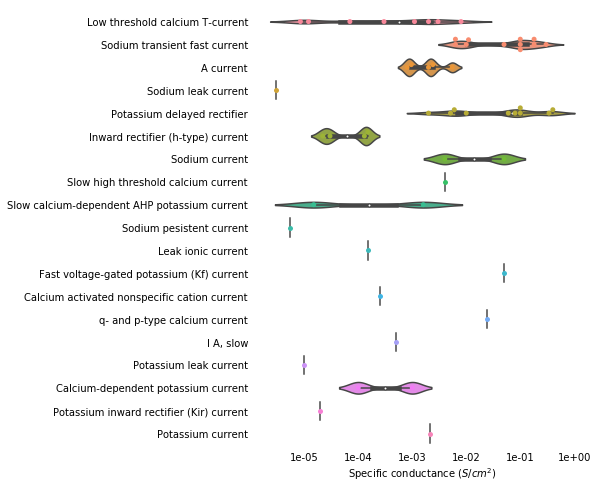

In [7]:
%matplotlib inline
# Plotting a violin plot for annotated values for specific conductances
# of the various kind of ionic currents 
plt.figure(figsize=(6, 8))
g = sns.violinplot(y="Transmembrane ionic current", x="Values", data=resultDF, bw=0.25)
g = sns.swarmplot( y="Transmembrane ionic current", x="Values", data=resultDF)
g.set_ylabel("")
g.set_xlabel("Specific conductance ($S/cm^2$)")
g.set_xticklabels([('%.0e' % 10**nb) for nb in g.get_xticks()]) 

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
#plt.plot()
plt.savefig('example_currents.png', bbox_inches='tight', transparent=True, dpi=200)


### Printing the JSON representation of a specific annotation of the plot

In [8]:
import json
record = resultDF[resultDF["Transmembrane ionic current"] == "Fast voltage-gated potassium (Kf) current"]
print(json.dumps(record["obj_annotation"].values[0].toJSON(), 
                 sort_keys=True, indent=4, separators=(',', ': ')))

{
    "annotId": "8e3edae6-ef34-11e5-ba5d-c869cd917532",
    "authors": [
        "iavarone",
        "oreilly"
    ],
    "comment": "Fast potassium current parameters",
    "experimentProperties": [],
    "localizer": {
        "location": 26404,
        "text": "The gKIR and the\nfast voltage-gated potassium channel ( gKf) had conductances of 20 \u0002s/\ncm2 and 50 mS/cm2, respectively. Both potassium channels had reversal\npotentials of 100 mV.",
        "type": "text"
    },
    "parameters": [
        {
            "description": {
                "depVar": {
                    "typeId": "BBP-030003",
                    "values": {
                        "statistic": "raw",
                        "type": "simple",
                        "unit": "mS/cm^2",
                        "values": [
                            50.0
                        ]
                    }
                },
                "type": "pointValue"
            },
            "id": "e47c93ba-ffdc-1

### Showing the annotated text in its context

In [9]:
nbContextChar = 400
context = record["obj_annotation"].values[0].getContext(nbContextChar)
from IPython.display import HTML
HTML(context[:nbContextChar] +  '<b>' + context[nbContextChar:-nbContextChar]
      + '</b>' + context[-nbContextChar:])